In [1]:
# Ledger based customizable CA
import math as m
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import random
import xarray as xr
import imageio
from scipy import signal
import seaborn as sns

In [2]:
                                 ''' Define Variables '''

''' Agent creation variables '''

Types = [-1,1]

# fitness function parameters
F_constant_1 = 1.0
F_constant_2 = 0.5

# cost function paramteres
C_constant_1 = 0.3
C_constant_2 = 0.15

''' Diffusion kernel'''

### gaussian kernel
Diffusion_Kernel = np.array([
    [1,     2,     1],
    [2,     4,     2],
    [1,     2,     1]])
Diffusion_Kernel = Diffusion_Kernel / sum(sum(Diffusion_Kernel)) # normalize
                                     
''' Define Functions '''


def Add_Agent(ID, Row, Column, Type, Alpha, Beta):
    '''  Agent Creating Function
    
    Add_Agent will return a new Agent in the form of a pd.DataFrame row. 
    This can be concatenated with the existing Ledger
    
    '''

    ledger = pd.DataFrame(dict( 
        ID      = [ID],
        Row     = Row,
        Column  = Column,
        Type    = Type,
        Alpha   = Alpha,
        Beta    = Beta,
        Alive   = 1
    ))
    
    ledger.set_index('ID', inplace=True)
    return(ledger)


def Save_Img(plot, filename):
    '''     Image saving function
    
    saves a plot as a PNG file to the location of your choice
    
    '''
    plt.clf()
    plt.imshow(plot, cmap='bwr')
    plt.axis('off')
    plt.savefig(filename)
    images.append(imageio.imread(filename))


def Eco_Effect(r, d = 1, sigma = 1): # r: diffusion radius, d: diffusion coeficient, sigma: sd
                       
    '''     Eco Diffusion function 
    
    Returns an Eco Diffusion Matrix, which is an np.array.
    
    This matrix contains the relative effects of nearby agents
    
    for example, the matrix [0,     0.125, 0,
                             0.125, 0.5,   0.125,
                             0,     0.125, 0] 
    indicates that 12.5% of the diffusible material from the agent directly 
    above the current actor will reach that actor. So that neighbor agent's Eco 
    effect * 0.125 will be the total conribution from that agent. The same
    applies for the agents next to the actor on all four cardinal directions. 
    In this example, cells on the immeadiet diagonal from the current actor 
    will contribute no ecological effect
    '''
                       
    grid = np.zeros((2*r + 1, 2*r + 1)) # create empty grid
    grid[r-1:r+2, r-1:r+2] = Diffusion_Kernel 
    #grid[r,r] = 1
    
    for i in range(r-1):
        grid = grid + signal.convolve2d(grid, Diffusion_Kernel,
                           mode='same', boundary='fill', fillvalue=0) 
        # ^^^ Create Eco_Diffusion_Matrix
        
    sigma = round(sigma)    
    
    if sigma > 1:
        sigma_grid = grid.copy()
        for i in range(sigma):
            sigma_grid = signal.convolve2d(sigma_grid, grid, mode='same', boundary='fill', fillvalue=0)
        grid = sigma_grid.copy()
        
    return(d*grid/sum(sum(grid))) # diffusion coefficient * normalized diff matrix 


def Death_Modifier(array, row, column):
    
    ''' Calculates ecological impact
    
    This function returns a float (Impact) that contains the total ecological impact from 
    all living agents within the previously definedspecified diffusion radius.
    
    The Impact float is interpretable as a death probability modifier. The base
    probability of death + Impact yields the new probability of death. In this way,
    negative values for 'Impact' will reduce the probability of death for the current actor.
    This is how cooperation can be introduced 
    '''
    
    PH_Field = array.copy()
    
    ### this chunk utilizes the interaction matrix. comment out for classic a/b shenanigans
    dummy = PH_Field.copy()
    Current_Types = [int(i) for i in list(np.unique(PH_Field[PH_Field > 0]))]
    for i in Current_Types:
        PH_Field[dummy == i] = Interaction_Matrix[Actor_Type-1, i-1]
    ###
    size = len(PH_Field[0:])
    
    col_start = column - Diffusion_Radius if column >= Diffusion_Radius else 0
    col_stop = column + 1 + Diffusion_Radius if column < (size - Diffusion_Radius) else size

    row_start = row - Diffusion_Radius if row >= Diffusion_Radius else 0
    row_stop = row + 1 + Diffusion_Radius if row < (size - Diffusion_Radius) else size

    #PH_Field = array.copy() #PH = 'place holder'
    if col_stop - col_start < 2*Diffusion_Radius + 1: # The following if else statements 
                                                      # implement periodic BC
        if col_start == 0:
            PH_Field = PH_Field.take(range(-(2*Diffusion_Radius +1 - col_stop),
                                               col_stop), axis=1, mode='wrap')
            col_stop = 2*Diffusion_Radius +1
        else:
            PH_Field = PH_Field.take(range(col_start, col_stop + 
                        (2*Diffusion_Radius + 1 - (col_stop - col_start))), axis=1, mode='wrap')
            col_start = 0
            col_stop = 2*Diffusion_Radius + 1 

    if row_stop - row_start < 2*Diffusion_Radius + 1:
        if row_start == 0:
            PH_Field = PH_Field.take(range(-(2*Diffusion_Radius +1 - row_stop),
                                               row_stop), mode='wrap', axis = 0)
            row_stop = 2*Diffusion_Radius + 1
        else:
            PH_Field = PH_Field.take(range(row_start, row_stop + 
                        (2*Diffusion_Radius + 1 - (row_stop - row_start))), mode='wrap', axis = 0)
            row_start = 0
            row_stop = 2*Diffusion_Radius + 1

    PH_Field = PH_Field[row_start:row_stop, col_start:col_stop]
    
    Impact = np.einsum('ij,ij->', PH_Field, Diffusion_Matrix)
    
    return(Impact)

def Fitness_Function(Alpha, Beta):
    return F_constant_1 * Alpha + F_constant_2 * Beta

def Cost_Function(Alpha, Beta):
    return C_constant_1 * Alpha + C_constant_2 * Beta

def CA_Plot(Parameter, Min = 0, Max = 1, scheme = "bwr", mask = 'black', field = True, colorbar = True, mask_value = 0):#    
    if Parameter == "Type":
        Max = seed_size + 1
    if Parameter == "ID":
        Max = max(Ledger.index)
    if field == True:
        masked_array = np.ma.masked_where(np.array(Fields.sel(Param = Parameter)) == mask_value, 
                                      np.array(Fields.sel(Param = Parameter)))
        cmap = cm.get_cmap(scheme).copy()
        cmap.set_bad(color = mask)
        plt.imshow(masked_array, cmap = cmap, vmin = Min, vmax = Max)
        if colorbar == True:
            plt.colorbar()
        plt.show()
    else:
        masked_array = np.ma.masked_where(Parameter == mask_value, 
                                      Parameter)
        cmap = cm.get_cmap(scheme).copy()
        cmap.set_bad(color = mask)
        plt.imshow(masked_array, cmap = cmap, vmin = Min, vmax = Max)
        if colorbar == True:
            plt.colorbar()
        plt.show()

In [3]:
### setup grid and interaction matrix ###
grid_size = 50;           assert type(grid_size) == int
seed_size = 16;           assert type(seed_size) == int and seed_size < grid_size

#    grid_size is the side length of the square field. seed_size is the square root 
#    of the total number of agents in the starting population

XX, YY = np.mgrid[0:grid_size,0:grid_size]
spaces = [XX.flatten(), YY.flatten()]

Length = len(XX.flatten())

coords = random.sample(range(grid_size**2), seed_size)

ID_count = range(1,seed_size + 1)

low = -2
high = 2
Interaction_Matrix = np.random.uniform(low = low, high = high, 
                                       size = (seed_size, seed_size))
Average_Interaction = abs((high+low)/2)

for i in range(seed_size):
    Interaction_Matrix[i,i] = 1

#^^^ interaction matrix has neutral interaction between same type. simplifying assumption
print(f"grid_size = {grid_size}, \nseed_size = {seed_size}, \
\nLength = {Length}, \ncoords = {coords}, \nID_count = {list(ID_count)}")

grid_size = 50, 
seed_size = 16, 
Length = 2500, 
coords = [2080, 2263, 194, 2057, 2228, 1355, 1120, 2120, 1998, 1014, 2479, 2298, 2301, 2486, 2288, 778], 
ID_count = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [4]:
''' setup the field ... '''
''' ...with randomly dispersed initial population  '''
XX, YY = np.mgrid[0:grid_size,0:grid_size]
spaces = [XX.flatten(), YY.flatten()]

Length = seed_size

coords = random.sample(range(grid_size**2), seed_size)

ID_count = range(1,seed_size + 1)

Ledger    = pd.DataFrame(dict(
    ID     = ID_count,
    Row    = spaces[0][coords],
    Column = spaces[1][coords],
    Type   = range(1, seed_size + 1),
    Alpha  = np.random.uniform(0, 1, size=Length),
    Beta   = np.random.uniform(0, 1, size=Length),
    Alive  = np.ones(Length)
))

Ledger.set_index('ID', inplace=True)
print(Ledger)

    Row  Column  Type     Alpha      Beta  Alive
ID                                              
1    44      37     1  0.368287  0.937372    1.0
2    21      24     2  0.379484  0.532843    1.0
3    38      36     3  0.554542  0.045993    1.0
4    30      29     4  0.746636  0.195188    1.0
5    28      42     5  0.673516  0.808027    1.0
6    37      10     6  0.912753  0.325413    1.0
7     4      31     7  0.185574  0.013329    1.0
8    17      20     8  0.008823  0.784115    1.0
9    37       7     9  0.117253  0.086407    1.0
10   25       7    10  0.397092  0.054984    1.0
11   16      18    11  0.931899  0.690897    1.0
12   47      30    12  0.554641  0.853428    1.0
13   44      31    13  0.663872  0.986896    1.0
14   45      28    14  0.336106  0.856498    1.0
15   18      33    15  0.922585  0.517840    1.0
16   25      39    16  0.110189  0.626988    1.0


In [5]:
'''         Create new field for each parameter         '''

fields = {field : np.zeros((grid_size, grid_size)) for field in 
          ['ID', 'Type', 'Alive', 'Alpha', 'Beta']} #always put ID first b/c indexing

for key in list(fields.keys())[1:]: # Exclude the ID values bc of weird indexing
    fields[key][Ledger['Row'], Ledger['Column']] = Ledger[key]
    
fields["ID"][Ledger['Row'], Ledger['Column']] = Ledger.index.get_level_values('ID') #Treat ID properly


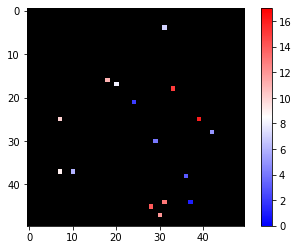

In [6]:
Fields = xr.DataArray(list(fields.values()), dims=("Param", "row", "col"), 
                  coords={"Param": list(fields.keys()), 
                          "row": range(grid_size), "col": range(grid_size)})

Fields.attrs={"General info": "This Data Array contains a stack of planes (The 'Param' dimension). Each plane corresponds to a parameter. The same x y coordinates across planes refer to the same agent",
         "placeholder":"skeep"}

CA_Plot("Type")

overpopulation


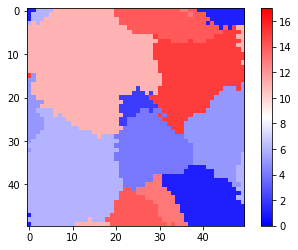

In [7]:
                              '''''''''    CA    '''''''''
Active_Steps = 0
Total_Steps = 0
images = []
Probs = []
Diversity = []
Ecos = []

''' create Diffusion_Matrix '''

Diffusion_Radius = 5
Diffusion_Matrix = Eco_Effect(Diffusion_Radius, d = 1, sigma = 1)
#Diffusion_Matrix = np.ones([grid_size,grid_size])+1.5

''' Run the simulation '''
while Active_Steps < 10000: #Active_Steps only increases if a cell divides or dies
    ''' Randomly select living agent '''
    if 0 >= int(Fields.sel(Param = "Alive").sum()): # avoid an infinite while loop
        print("everyone ded")
        break
        
    elif int(Fields.sel(Param = "Alive").sum()) >= grid_size**2:
        print("overpopulation")
        break
        
    else:
        while Active_Steps > -1: #while loop only ends when following if statement is true
            row = random.randint(0,grid_size-1); col = random.randint(0,grid_size-1)
            if int(Fields.sel(Param = "Alive", row = row, col = col)) == 1: 
                # ^^ select random spots until a living agent is selected
                break

    Actor_ID = int(Fields.sel(Param = "ID", row = row, col = col))
    Actor_Type = int(Fields.sel(Param = "Type", row = row, col = col))
    Actor_Alpha = float(Fields.sel(Param = "Alpha", row = row, col = col))
    Actor_Beta = float(Fields.sel(Param = "Beta", row = row, col = col))
    # ^^ Store some of the actors parameter values into new variables for easy reference

    ''' Cell cycle dynamics '''

    Prob_of_life = (Fitness_Function(Actor_Alpha, Actor_Beta) - 
    Cost_Function(Actor_Alpha, Actor_Beta))# baseline probability of death
    
    Eco = Death_Modifier(np.array(Fields.sel(Param = "Type")), row, col)
    
    Prob_of_life = Prob_of_life + Eco
    
    Probs.append(Prob_of_life)
    Ecos.append(Eco)
    
    if random.random() > Prob_of_life: 

        ''' Death '''
        Ledger.loc[Actor_ID, "Alive"] = 0 #change alive status in ledger
        
        for params in list(fields.keys()): # remove agent from all fields
            Fields.loc[params, row, col] = 0


        Active_Steps += 1
        Diversity.append(len(np.unique(Fields.sel(Param = "Type"))[1:]))

     #       filename = 'CA_Movies/CA'+str(Steps)+'.png'
     #       Save_Img(Field*-1, filename) #save img

    else:

        ''' let agent divide '''
        X_local, Y_local = np.mgrid[row-1:row+2, col-1:col+2] #coords of neighborhood
        
        X_local = np.where(X_local == -1, grid_size-1, X_local)
        X_local = np.where(X_local == grid_size, 0, X_local)

        Y_local = np.where(Y_local == -1, grid_size-1, Y_local)
        Y_local = np.where(Y_local == grid_size, 0, Y_local) # implements wrap BC

        Free = np.array(Fields.sel(Param = "Alive"))[X_local, Y_local] == 0 
        # ^^ Indicates where there are free spaces

        Free_X = X_local[Free]
        Free_Y = Y_local[Free]
        # ^^^ Identify free spaces surrounding actor 

        if len(Free_X) > 0:

            Random_Space = random.randint(1, len(Free_X))

            New_Space = [Free_X[Random_Space - 1], Free_Y[Random_Space - 1]] 
            
            New_Agent = Add_Agent(ID = len(Ledger.Row)+1, Row = New_Space[0],
                      Column = New_Space[1], Type = Actor_Type, Alpha = Actor_Alpha, 
                      Beta = Actor_Beta)
            
            Ledger = pd.concat([Ledger, New_Agent])
                                                                                                    
            for params in list(fields.keys()): # probably a faster way to do this
                if params == "Alive":
                    Fields.loc[params, New_Space[0], New_Space[1]] = int(New_Agent[params]) 
                elif params == "ID":
                    Fields.loc[params, New_Space[0], New_Space[1]] = int(New_Agent.index.values)
                else:
                    Fields.loc[params, New_Space[0], New_Space[1]] = float(New_Agent[params])
            
            Active_Steps += 1
            Diversity.append(len(np.unique(Fields.sel(Param = "Type"))[1:]))
    Total_Steps += 1
#            filename = 'CA_Movies/CA'+str(Active_Steps)+'.png'
#            Save_Img(Field*-1, filename) #save img

#imageio.mimsave('CA_Movies/CA_movie_d0.gif', images)
CA_Plot("Type")

[2680, 17137]


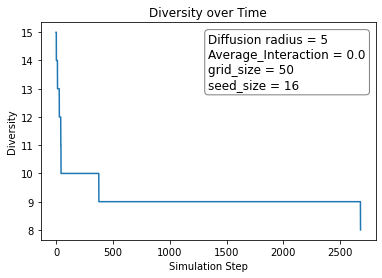

<AxesSubplot:ylabel='Density'>

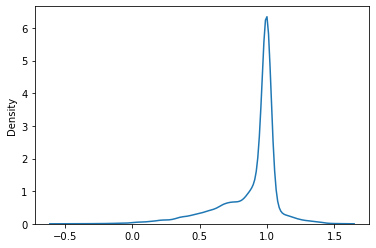

In [9]:

sim_info = f"Diffusion radius = {Diffusion_Radius} \nAverage_Interaction = {Average_Interaction}\
\ngrid_size = {grid_size} \nseed_size = {seed_size}" # Set the simulation information here

plt.plot(Diversity)
plt.xlabel('Simulation Step')
plt.ylabel('Diversity')
plt.title('Diversity over Time')
plt.text(0.5, 0.95, sim_info, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

print([Active_Steps,Total_Steps])
plt.show()
sns.kdeplot(Ecos)






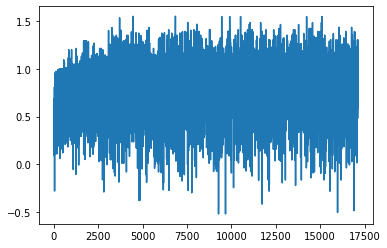

In [10]:
plt.plot(Ecos)

In [8]:
''' Graveyard '''
# #######
# df = Ledger
# Row = 2
# Column = 2
# NHood = [[-1,-1], [-1,0], [-1,1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]
# #Neighbors = pd.DataFrame([df[(df['Row'] == Row + spots[0]) & \
#                     #(df['Column'] == Column + spots[1])] for spots in NHood])

# Neighbors = pd.DataFrame()
# for spots in NHood: # does not account for death yet ###############
#     Agent_Finder = np.array((Ledger['Row'] == Row + spots[0]) & \
#         (df['Column'] == Column + spots[1]))# This is not efficient
#     Agent_Finder = [Index for Index, Bool in enumerate(Agent_Finder) if Bool == True]
#     if len(Agent_Finder) > 0:
#         if int(Ledger.loc[Agent_Finder, 'Alive']) = 1:
#             Neighbors = pd.concat([Neighbors, Ledger.iloc[[int(Agent_Finder[0])]]])
#         #Agents.append(Agent_Finder)


# #Neighbors
# int(Ledger.loc[Agent_Finder, 'Alive'])
# #######

# #######
# NHood = [[-1,-1], [-1,0], [-1,1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]


# Agent_Finder = np.array((Ledger['Row'] == Row + NHood[7][0]) & \
#         (df['Column'] == Column + NHood[7][1]))#.astype(int)
# [Index for Index, Bool in enumerate(Agent_Finder) if Bool == True]


# Hood(2,3,Ledger)
# #######

# #######
# Live_Agents = Ledger[Ledger['Alive'] == 1].reset_index(drop=True)
# for i in range(0, len(Live_Agents)):
#     Field[int(Live_Agents.loc[i,["Row"]]),int(Live_Agents.loc[i,["Column"]])] = int(Live_Agents.loc[i,["Type"]])
    

# Field
# Actor
# #######

# #######
# n=3
# seed=3
# grid = np.zeros((n*2+1,n*2+1))

# def Eco_Effect(r,d): # r is the diffusion radius, d is diffusion coeficient 
#     grid = np.zeros((r*2+1,r*2+1)) # create empty grid
#     grid[int((r*2+1)/2),int((r*2+1)/2)] = 1 #
    
#     for i in range(r):
#         grid = grid + signal.convolve2d(grid, Diffusion_Kernel, \
#                mode='same', boundary='fill', fillvalue=0)*d # Create Eco_Diffusion_Matrix
    
#     return(grid)

# print(Eco_Effect(1,0.75))
# #plt.imshow(grid, cmap='bwr', origin='lower')
# #######

# #######
# print(sum(sum(grid)))

# grid = grid + signal.convolve2d(grid, kernel_2, mode='same', boundary='fill', fillvalue=0)
# #grid = (grid / np.amax(abs(grid)))


# plt.imshow(grid, cmap='bwr')
# print(sum(sum(grid)))
# print(grid)
# #######

# ####### using list comprehension and dictionaries to do cool stuff quickly
# fields = {field:np.zeros((grid_size, grid_size)) for field in 
#           ['Type', 'Eco', 'Alive', 'Fitness']}

# for key in fields.keys():
#     fields[key][Ledger['Row'], Ledger['Column']] = Ledger[key]
# #######

' Graveyard '